## Query GPT-4 for name and analysis using a toy example

#### This uses an improved version of the original prompt that includes instructions to generate an LLM Confidence Score.

#### The prompt also includes an example analysis to help the LLM in its task.

#### The LLM Score has its own column in the output TSV file.

#### The JSON config file is updated to use "GPT-4_1106-preview" build.

Update 12-21-2023

new available models through api: https://api.llm.ideker.ucsd.edu/api/chat

available models:

| NAME           | ID           | SIZE   |
|----------------|--------------|--------|
| llama2:70b     | c3a7af098300 | 38 GB  |
| llama2:7b      | fe938a131f40 | 3.8 GB |
| llama2:latest  | fe938a131f40 | 3.8 GB |
| mistral:7b     | 4d9f4b269c33 | 4.1 GB |
| mixtral:latest | 99a9202f8a7a | 26 GB  |

In [ ]:
import pandas as pd
import json 
from utils.openai_query import openai_chat
from utils.prompt_factory import make_user_prompt_with_score
from utils.server_model_query import server_model_chat
from utils.llm_analysis_utils import process_analysis, save_progress
from tqdm import tqdm
import openai
import os
import logging
import re
%load_ext autoreload
%autoreload 2


**Default run is using GPT4**

In [11]:
## load variables
initialize = True # if True, then initialize the input table with llm names, analysis and score to None 
# Replace with your actual values
config_file = './jsonFiles/toyexample.json'  # replace with your actual config file 
input_file = 'data/GO_term_analysis/toy_example_w_contaminated.csv' # replace with your actual input file
input_sep = ','  # replace with the separator
set_index = 'GO'  # replace with your column name that you want to set as index or None
gene_column = 'Genes'  # replace with your actual column name for the gene list
gene_sep = ' '  # replace with your actual separator
gene_features = None  # replace with your path to the gene features or None if you don't want to include in the prompt
direct = False # if True, then the prompt will be a direct sentence asking for a name and analysis from the gene set, otherwise default or customized prompt
out_file = 'data/GO_term_analysis/LLM_processed_toy_example_w_contamination_gpt4'  # replace with your actual output file name

customized_prompt = False # if True, then the prompt will be the custom prompt, if False, then the prompt will use default

# load the config file
with open(config_file) as json_file:
    config = json.load(json_file)

if customized_prompt:
    # make sure the file exist 
    if os.path.isfile(config['CUSTOM_PROMPT_FILE']):
        with open(config['CUSTOM_PROMPT_FILE'], 'r') as f: # replace with your actual customized prompt file
            customized_prompt = f.read()
            assert len(customized_prompt) > 1, "Customized prompt is empty"
    else:
        print("Customized prompt file does not exist")
        customized_prompt = None
else:
    customized_prompt = None

# Load OpenAI key, context, and model used 
openai.api_key = os.environ["OPENAI_API_KEY"]

context = config['CONTEXT']
model = config['MODEL']
temperature = config['TEMP']
max_tokens = config['MAX_TOKENS']
if model.startswith('gpt'):
    rate_per_token = config['RATE_PER_TOKEN']
    DOLLAR_LIMIT = config['DOLLAR_LIMIT']
LOG_FILE = config['LOG_NAME']+'_log.json'

SEED = 42
column_prefix = model.split('-')[0]

In [12]:
# handel the logger so it create a new one for each model run
def get_logger(filename):
    logger = logging.getLogger(filename)
    logger.setLevel(logging.INFO)
    if not logger.handlers:
        file_handler = logging.FileHandler(filename)
        formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
        file_handler.setFormatter(formatter)
        logger.addHandler(file_handler)
    return logger


def main(df):
    analysis_dict  = {}

    logger = get_logger(f'{out_file}.log')

    i = 0 #used for track progress and saving the file
    for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
        #only process None rows 
        if row[f'{column_prefix} Analysis'] is not None:
            continue
        
        gene_data = row[gene_column]
        # if gene_data is not a string, then skip
        if type(gene_data) != str:
            
            logger.warning(f'Gene set {idx} is not a string, skipping')
            continue
        genes = gene_data.split(gene_sep)
        
        if len(genes) >1000:
            logger.warning(f'Gene set {idx} is too big, skipping')
            continue

        try:
            prompt = make_user_prompt_with_score(genes)
            # print(prompt)
            finger_print = None
            if model.startswith('gpt'):
                print("Accessing OpenAI API")
                analysis, finger_print = openai_chat(context, prompt, model, temperature, max_tokens, rate_per_token, LOG_FILE, DOLLAR_LIMIT, SEED)
            else:
                print("Using server model")
                analysis, error_message= server_model_chat(context, prompt, model, temperature, max_tokens,LOG_FILE, SEED)

            
            if analysis:
                # print(analysis)
                llm_name, llm_score, llm_analysis = process_analysis(analysis)
                # clean up the score and return float
                llm_score =  float(re.sub("[^0-9.-]", "", llm_score))
                
                df.loc[idx, f'{column_prefix} Name'] = llm_name
                df.loc[idx, f'{column_prefix} Analysis'] = llm_analysis
                df.loc[idx, f'{column_prefix} Score'] = llm_score
                analysis_dict[f'{idx}_{column_prefix}'] = analysis
                # Log success with fingerprint
                logger.info(f'Success for {idx} {column_prefix}.')
                if finger_print:
                    logger.info(f'GPT_Fingerprint for {idx}: {finger_print}')
                    
            else:
                logger.error(f'Error for query gene set {idx}: {error_message}')

        except Exception as e:
            logger.error(f'Error for {idx}: {e}')
            continue
        i += 1
        if i % 10 == 0:
            save_progress(df, analysis_dict, out_file)
            # df.to_csv(f'{out_file}.tsv', sep='\t', index=True)
            print(f"Saved progress for {i} genesets")
    

In [13]:
#Define your own loop for running the pipeline
## 12-18-2023: this loop is for run the default gene set and the contaminated gene sets 
## can modify this loop for different models or only run on default gene set

if __name__ == "__main__":
    
    df = pd.read_csv(input_file, sep=input_sep, index_col=set_index)
    
    column_prefix = model.split('-')[0] + '_default' #this is default
    
    if initialize:
        # initialize the input file with llm names, analysis and score to None
        df[f'{column_prefix} Name'] = None
        df[f'{column_prefix} Analysis'] = None
        df[f'{column_prefix} Score'] = None
    main(df)  ## run with the real set 
    
    ## run the pipeline for contaiminated gene sets 
    contaminated_columns = [col for col in df.columns if col.endswith('contaminated_Genes')]
    # print(contaminated_columns)
    for col in contaminated_columns:
        gene_column = col ## Note need to change the gene_column to the contaminated column
        contam_prefix = '_'.join(col.split('_')[0:2])
        column_prefix = model.split('-')[0] + '_' +contam_prefix
        print(column_prefix)

        if initialize:
            # initialize the input file with llm names, analysis and score to None
            df[f'{column_prefix} Name'] = None
            df[f'{column_prefix} Analysis'] = None
            df[f'{column_prefix} Score'] = None
        main(df)
    # df.head()


  0%|          | 0/10 [00:00<?, ?it/s]

Accessing OpenAI API


 10%|█         | 1/10 [00:59<08:56, 59.62s/it]

2003
Accessing OpenAI API


 20%|██        | 2/10 [01:39<06:25, 48.25s/it]

1605
Accessing OpenAI API


 30%|███       | 3/10 [03:07<07:43, 66.16s/it]

1833
Accessing OpenAI API


 40%|████      | 4/10 [03:51<05:43, 57.32s/it]

1746
Accessing OpenAI API


 50%|█████     | 5/10 [04:51<04:52, 58.57s/it]

2107
Accessing OpenAI API


 60%|██████    | 6/10 [06:11<04:23, 65.80s/it]

2092
Accessing OpenAI API


 70%|███████   | 7/10 [06:54<02:54, 58.26s/it]

1909
Accessing OpenAI API


 80%|████████  | 8/10 [07:12<01:30, 45.37s/it]

1277
Accessing OpenAI API


 90%|█████████ | 9/10 [08:17<00:51, 51.45s/it]

1572
Accessing OpenAI API


100%|██████████| 10/10 [08:34<00:00, 51.44s/it]


1270
Saved progress for 10 genesets
gpt_50perc_contaminated


  0%|          | 0/10 [00:00<?, ?it/s]

Accessing OpenAI API


 10%|█         | 1/10 [00:49<07:24, 49.35s/it]

1910
Accessing OpenAI API


 20%|██        | 2/10 [01:57<08:01, 60.23s/it]

1615
Accessing OpenAI API


 30%|███       | 3/10 [03:08<07:36, 65.23s/it]

1559
Accessing OpenAI API


 40%|████      | 4/10 [04:04<06:08, 61.47s/it]

1586
Accessing OpenAI API


 50%|█████     | 5/10 [05:10<05:16, 63.28s/it]

1902
Accessing OpenAI API


 60%|██████    | 6/10 [06:13<04:12, 63.13s/it]

1897
Accessing OpenAI API


 70%|███████   | 7/10 [07:08<03:01, 60.45s/it]

1903
Accessing OpenAI API


 80%|████████  | 8/10 [07:33<01:38, 49.18s/it]

1344
Accessing OpenAI API


 90%|█████████ | 9/10 [08:12<00:45, 45.89s/it]

1599
Accessing OpenAI API


100%|██████████| 10/10 [08:37<00:00, 51.78s/it]


1265
Saved progress for 10 genesets
gpt_100perc_contaminated


  0%|          | 0/10 [00:00<?, ?it/s]

Accessing OpenAI API


 10%|█         | 1/10 [00:35<05:21, 35.71s/it]

1698
Accessing OpenAI API


 20%|██        | 2/10 [01:17<05:12, 39.06s/it]

1418
Accessing OpenAI API


 30%|███       | 3/10 [02:28<06:16, 53.86s/it]

1861
Accessing OpenAI API


 40%|████      | 4/10 [03:53<06:36, 66.11s/it]

1817
Accessing OpenAI API


 50%|█████     | 5/10 [04:26<04:31, 54.27s/it]

1744
Accessing OpenAI API


 60%|██████    | 6/10 [04:55<03:01, 45.47s/it]

1641
Accessing OpenAI API


 70%|███████   | 7/10 [05:41<02:16, 45.62s/it]

1849
Accessing OpenAI API


 80%|████████  | 8/10 [06:10<01:21, 40.54s/it]

1409
Accessing OpenAI API


 90%|█████████ | 9/10 [06:33<00:34, 34.86s/it]

1439
Accessing OpenAI API


100%|██████████| 10/10 [06:51<00:00, 41.20s/it]

1320
Saved progress for 10 genesets


In [15]:
# change to use mistral and llama2
SEED = 42
model_options = ['mistral:7b', 'mixtral:latest', 'llama2:7b', 'llama2:70b']


if __name__ == "__main__":
    for m in model_options:
        
        model = m
        name_fix = '_'.join(model.split(':'))
        # same input but change output for different models to avoid overwriting
        out_file = f'data/GO_term_analysis/LLM_processed_toy_example_w_contamination_{name_fix}'  # save to the same file name as the input file
        LOG_FILE = config['LOG_NAME']+f'_{name_fix}'+'_log.json'

        df = pd.read_csv(input_file, sep=input_sep, index_col=set_index)
        
        # print(df.head())
        column_prefix = name_fix + '_default' #this is default
        print(column_prefix)
        if initialize:
            # initialize the input file with llm names, analysis and score to None
            df[f'{column_prefix} Name'] = None
            df[f'{column_prefix} Analysis'] = None
            df[f'{column_prefix} Score'] = None
        main(df)  ## run with the real set 
        
        ## run the pipeline for contaiminated gene sets 
        contaminated_columns = [col for col in df.columns if col.endswith('contaminated_Genes')]
        # print(contaminated_columns)
        for col in contaminated_columns:
            gene_column = col ## Note need to change the gene_column to the contaminated column
            contam_prefix = '_'.join(col.split('_')[0:2])
            column_prefix = name_fix + '_' +contam_prefix
            print(column_prefix)

            if initialize:
                # initialize the input file with llm names, analysis and score to None
                df[f'{column_prefix} Name'] = None
                df[f'{column_prefix} Analysis'] = None
                df[f'{column_prefix} Score'] = None
            main(df)
            
print("Done")

mistral_7b_default


  0%|          | 0/10 [00:00<?, ?it/s]

Using server model


 10%|█         | 1/10 [00:42<06:22, 42.45s/it]

Using server model


 20%|██        | 2/10 [01:02<03:51, 28.99s/it]

Using server model


 30%|███       | 3/10 [01:26<03:07, 26.81s/it]

Using server model


 40%|████      | 4/10 [01:42<02:15, 22.56s/it]

Using server model


 50%|█████     | 5/10 [02:10<02:02, 24.57s/it]

Using server model


 60%|██████    | 6/10 [02:37<01:41, 25.44s/it]

Using server model


 70%|███████   | 7/10 [03:02<01:16, 25.40s/it]

Using server model


 80%|████████  | 8/10 [03:12<00:40, 20.23s/it]

Using server model


 90%|█████████ | 9/10 [03:30<00:19, 19.55s/it]

Using server model


100%|██████████| 10/10 [03:39<00:00, 21.95s/it]


Saved progress for 10 genesets
mistral_7b_50perc_contaminated


  0%|          | 0/10 [00:00<?, ?it/s]

Using server model


 10%|█         | 1/10 [00:26<04:00, 26.73s/it]

Using server model


 20%|██        | 2/10 [00:46<02:59, 22.42s/it]

Using server model


 30%|███       | 3/10 [01:10<02:42, 23.24s/it]

Using server model


 40%|████      | 4/10 [01:26<02:03, 20.63s/it]

Using server model


 50%|█████     | 5/10 [01:54<01:55, 23.02s/it]

Using server model


 60%|██████    | 6/10 [02:22<01:38, 24.66s/it]

Using server model


 70%|███████   | 7/10 [02:48<01:16, 25.38s/it]

Using server model


 80%|████████  | 8/10 [02:58<00:40, 20.22s/it]

Using server model


 90%|█████████ | 9/10 [03:15<00:19, 19.38s/it]

Using server model


100%|██████████| 10/10 [03:25<00:00, 20.51s/it]


Saved progress for 10 genesets
mistral_7b_100perc_contaminated


  0%|          | 0/10 [00:00<?, ?it/s]

Using server model


 10%|█         | 1/10 [00:27<04:07, 27.48s/it]

Using server model


 20%|██        | 2/10 [00:46<02:58, 22.31s/it]

Using server model


 30%|███       | 3/10 [01:13<02:52, 24.61s/it]

Using server model


 40%|████      | 4/10 [01:40<02:32, 25.44s/it]

Using server model


 50%|█████     | 5/10 [02:00<01:57, 23.59s/it]

Using server model


 60%|██████    | 6/10 [02:27<01:39, 24.80s/it]

Using server model


 70%|███████   | 7/10 [02:54<01:16, 25.59s/it]

Using server model


 80%|████████  | 8/10 [03:03<00:40, 20.26s/it]

Using server model


 90%|█████████ | 9/10 [03:25<00:20, 20.77s/it]

Using server model


100%|██████████| 10/10 [03:34<00:00, 21.42s/it]


Saved progress for 10 genesets
mixtral_latest_default


  0%|          | 0/10 [00:00<?, ?it/s]

Using server model
Encountering server issue. Retrying in  10  seconds
Encountering server issue. Retrying in  20  seconds
Encountering server issue. Retrying in  40  seconds
Encountering server issue. Retrying in  80  seconds
Encountering server issue. Retrying in  160  seconds
Encountering server issue. Retrying in  320  seconds


 10%|█         | 1/10 [16:30<2:28:34, 990.54s/it]

Using server model


 20%|██        | 2/10 [17:27<58:49, 441.24s/it]  

Using server model


 30%|███       | 3/10 [18:15<30:33, 261.89s/it]

Using server model


 40%|████      | 4/10 [18:59<17:34, 175.82s/it]

Using server model


 50%|█████     | 5/10 [19:48<10:50, 130.08s/it]

Using server model


 60%|██████    | 6/10 [20:44<06:59, 104.81s/it]

Using server model


 70%|███████   | 7/10 [21:39<04:26, 88.70s/it] 

Using server model


 80%|████████  | 8/10 [22:15<02:23, 71.84s/it]

Using server model


 90%|█████████ | 9/10 [23:03<01:04, 64.26s/it]

Using server model


100%|██████████| 10/10 [23:39<00:00, 142.00s/it]


Saved progress for 10 genesets
mixtral_latest_50perc_contaminated


  0%|          | 0/10 [00:00<?, ?it/s]

Using server model
Encountering server issue. Retrying in  10  seconds
Encountering server issue. Retrying in  20  seconds
Encountering server issue. Retrying in  40  seconds
Encountering server issue. Retrying in  80  seconds
Encountering server issue. Retrying in  160  seconds
Encountering server issue. Retrying in  320  seconds


 10%|█         | 1/10 [16:30<2:28:34, 990.49s/it]

Using server model


 20%|██        | 2/10 [17:30<59:03, 442.95s/it]  

Using server model


 30%|███       | 3/10 [18:29<31:15, 267.92s/it]

Using server model


 40%|████      | 4/10 [19:10<17:50, 178.39s/it]

Using server model


 50%|█████     | 5/10 [20:09<11:15, 135.01s/it]

Using server model


 60%|██████    | 6/10 [21:03<07:10, 107.69s/it]

Using server model
Encountering server issue. Retrying in  10  seconds
Encountering server issue. Retrying in  20  seconds
Encountering server issue. Retrying in  40  seconds
Encountering server issue. Retrying in  80  seconds
Encountering server issue. Retrying in  160  seconds
Encountering server issue. Retrying in  320  seconds


 70%|███████   | 7/10 [37:34<19:48, 396.33s/it]

Using server model


 80%|████████  | 8/10 [38:23<09:31, 285.92s/it]

Using server model


 90%|█████████ | 9/10 [39:06<03:29, 210.00s/it]

Using server model


100%|██████████| 10/10 [39:40<00:00, 238.10s/it]


Saved progress for 10 genesets
mixtral_latest_100perc_contaminated


  0%|          | 0/10 [00:00<?, ?it/s]

Using server model
Encountering server issue. Retrying in  10  seconds
Encountering server issue. Retrying in  20  seconds
Encountering server issue. Retrying in  40  seconds
Encountering server issue. Retrying in  80  seconds
Encountering server issue. Retrying in  160  seconds


In [6]:
import pandas as pd 
score_df = pd.read_csv(f'{out_file}.tsv', sep = '\t')
score_df

,GO,Genes,Gene_Count,Term_Description,50perc_contaminated_Genes,100perc_contaminated_Genes,gpt_default Name,gpt_default Analysis,gpt_default Score,gpt_50perc_contaminated Name,gpt_50perc_contaminated Analysis,gpt_50perc_contaminated Score,gpt_100perc_contaminated Name,gpt_100perc_contaminated Analysis,gpt_100perc_contaminated Score
0,GO:0070350,FGF10 FTO VSTM2A,3,regulation of white fat cell proliferation,FGF10 INPP5J STXBP5,BCORL1 DEFB1 SS18L2,Regulation of Developmental Growth and Energy ...,1. FGF10 (Fibroblast Growth Factor 10) is a me...,0.85,Regulation of Cellular Growth and Vesicular Tr...,1. FGF10 (Fibroblast Growth Factor 10) is a me...,0.85,System of unrelated proteins,1. BCORL1 (BCL6 corepressor-like 1) is a trans...,0.00
1,GO:0051936,SLC6A12 SLC6A11 SLC6A1 SLC6A13,4,gamma-aminobutyric acid reuptake,SLC6A11 SLC6A1 ENDOD1 LGALS7B,CSRNP3 ZNF572 RPL10 EXOSC4,Neurotransmitter Transport and Regulation,"1. SLC6A12, also known as the betaine/GABA tra...",0.95,Neurotransmitter Transport and Glycoprotein Mo...,"1. SLC6A11, also known as GAT3, is a GABA tran...",0.85,System of unrelated proteins,1. CSRNP3 (Cysteine and Serine Rich Nuclear Pr...,0.00
2,GO:0070646,USP17L10 USP29 TNIP1 USP17L3 USP20 USP5 USP18 ...,135,protein modification by small protein removal,TNIP1 USP17L20 ABRAXAS1 USP38 USP17L21 USP14 U...,RPS27 PSMA3 EDC3 KLK13 TRIB2 PLA2G4E SLU7 UBLC...,Ubiquitin-Proteasome System Regulation and Deu...,"1. The majority of the proteins listed, includ...",0.98,Ubiquitin-Proteasome System Regulation and Deu...,"1. The majority of the proteins listed, such a...",0.92,System of unrelated proteins,The provided list of interacting proteins enco...,0.00
3,GO:0071318,P2RY2 P2RY4 CIB2 PTGS2 P2RX7 TRPM4 SSH1 TAF1 P...,18,cellular response to ATP,PDXP P2RY4 TRPM4 TOP2B RYR3 P2RY1 HSP90B1 P2RY...,TDRP NAA30 SEPTIN6 HVCN1 SLC24A2 ZNF397 OR6C65...,Purinergic Signaling and Associated Cellular R...,1. P2RY2 and P2RY4 are G-protein-coupled recep...,0.88,System of unrelated proteins,"1. PDXP, also known as pyridoxal phosphatase, ...",0.00,System of unrelated proteins,1. TDRP (Testis Development Related Protein) i...,0.00
4,GO:0038183,ABCB11 ABCG5 CYP8B1 ABCG8 NR1H4 PRKAA1 CIDEB V...,11,bile acid signaling pathway,CYP8B1 GPBAR1 VDR ABCG8 CYP7A1 CMTR1 SNX1 SLC2...,SYT10 NOPCHAP1 CLIP4 P3R3URF MAGOH SLC43A2 GLI...,Bile Acid Synthesis and Regulation,"1. ABCB11, also known as the bile salt export ...",0.95,Bile Acid Synthesis and Regulation,1. CYP7A1 is a key enzyme in the cholesterol c...,0.85,System of unrelated proteins,1. SYT10 (Synaptotagmin-10) is a member of the...,0.00
5,GO:0001973,NECAB2 ADA ADORA3 ACP3 P2RY12 ADORA1 GNAI2 ADO...,11,G protein-coupled adenosine receptor signaling...,ADORA1 P2RY12 ADCY5 ADA GNAI2 OSCP1 RCL1 ZMYND...,EHF GCOM1 MAP7D2 KRT13 ENAM NKAIN4 HAUS6 TUBD1...,Purinergic Signaling in Neurotransmission and ...,1. NECAB2 (N-terminal EF-hand calcium-binding ...,0.92,Purinergic Signaling and Adenosine Metabolism,"1. ADORA1 is the adenosine A1 receptor, which ...",0.85,System of unrelated proteins,1. EHF (Ets homologous factor) is a transcript...,0.00
6,GO:0051349,RAF1 NF1 ADORA3 EDNRA ADCYAP1 FSHR LINC02210-C...,40,positive regulation of lyase activity,CACNA1D ADORA3 TSHR PARK7 ADORA2B DRD1 RXFP1 C...,KRT79 PPP1R3A MLXIPL NR1H4 SPACA3 ZIK1 PPP1R2 ...,G-Protein Coupled Receptor (GPCR) Signaling an...,1. RAF1 is a serine/threonine kinase that play...,0.92,G-protein coupled receptor signaling and cellu...,1. CACNA1D encodes a voltage-dependent L-type ...,0.85,System of unrelated proteins,1. KRT79 is a type II keratin found in the inn...,0.00
7,GO:0009698,CYP2A7 UGT1A7 CYP2A13 UGT1A8 CYP2A6 CYP1A1 CYP2D6,7,phenylpropanoid metabolic process,CYP1A1 CYP2A6 UGT1A8 RNF126 KLHDC10 ARHGEF4 VRK3,RPL27A MAN2A2 KIF5C CRHR1 ZNF385A NEDD9 TBC1D13,Xenobiotic Metabolism and Detoxification,1. CYP2A7 is a member of the cytochrome P450 s...,0.92,Xenobiotic Metabolism and Protein Ubiquitination,1. CYP1A1 is a member of the cytochrome P450 s.

/tmp/ipykernel_226048/1712979539.py:31: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Gene Count')


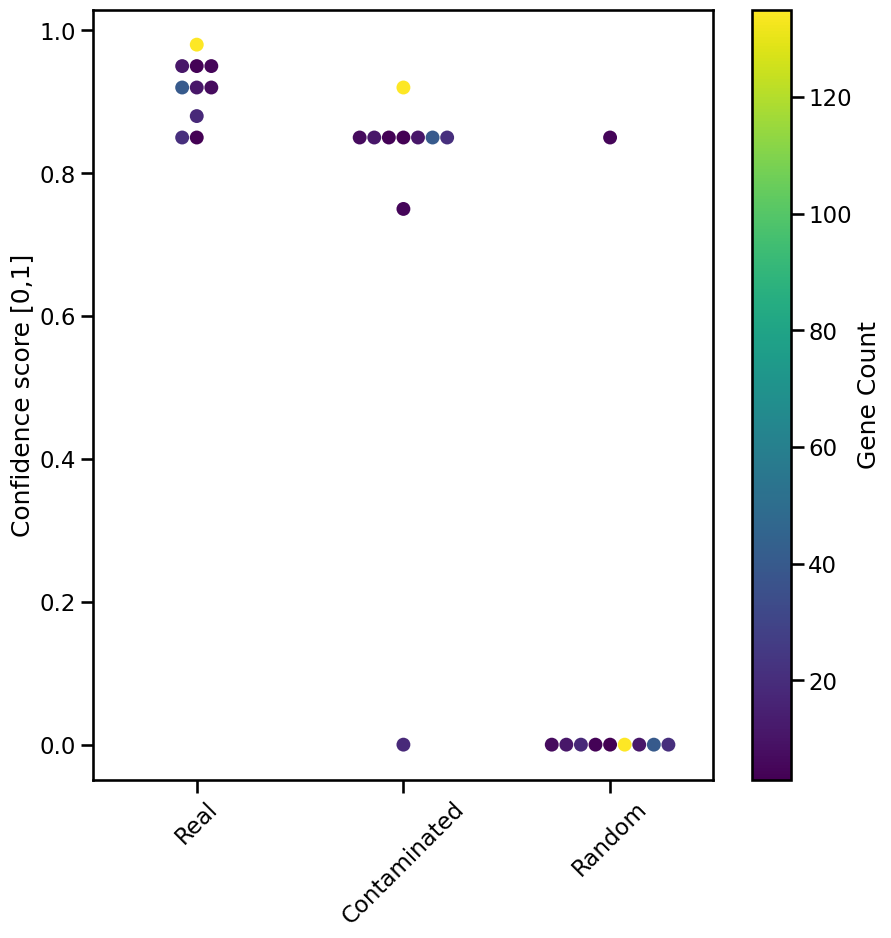

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_context('talk')
plt.figure(figsize=(10, 10))
columns_score = [col for col in score_df.columns if col.endswith('Score')]

filtered_score_df = score_df[['GO', 'Gene_Count']+columns_score]
long_scores = filtered_score_df.melt(id_vars=['GO', 'Gene_Count'], var_name='Score Type', value_name='Score')

long_scores.head()
long_scores.Score = long_scores.Score.astype(float)
sns.swarmplot(x='Score Type', y='Score', data=long_scores, size=10, hue='Gene_Count', palette='viridis', edgecolor='none', legend=False, alpha=1)

# # Draw lines between points with the same 'GO'
# for name, group in long_scores.groupby('GO'):
#     if len(group) > 1:
#         plt.plot(group['Score Type'], group['Score'], marker='', color='grey', linewidth=1, alpha=0.5)

plt.xticks(ticks=np.arange(len(long_scores['Score Type'].unique())),labels=['Real', 'Contaminated', 'Random'], rotation=45)

plt.xlabel('')
plt.ylabel('Confidence score [0,1]')

# Create a colorbar for the continuous hue
norm = plt.Normalize(long_scores['Gene_Count'].min(), long_scores['Gene_Count'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])

# Add the colorbar to the plot
plt.colorbar(sm, label='Gene Count')

plt.show()


In [ ]:
# test the script for batch run

input_file = 'data/GO_term_analysis/toy_example.csv'
config = './jsonFiles/GOLLMrun_config.json'
%run query_llm_for_analysis.py --input $input_file --start 0 --end 1 --config $config

## Checkout and combine the output from the batch run 

In [ ]:
from glob import glob
import pandas as pd
import json

### sanity check code along the way
processed_files = glob('data/GO_term_analysis/LLM_processed_selected_go_terms*.tsv')

for file in processed_files:
    df = pd.read_csv(file, sep='\t')
    df.set_index('GO', inplace=True)
    ranges = file.split('/')[-1].split('.')[0].split('_')[5:7]
    with open(f'data/GO_term_analysis/LLM_response_go_terms_{ranges[0]}_{ranges[1]}.json') as fp:
        llm_response_dict = json.load(fp)
    for go_term, row in df.iterrows():
        if llm_response_dict[go_term] == 'NO ANALYSIS':
            print(file.split('/')[-1])
            print(f'No analysis for {go_term}')
            continue
        else:
            llm_analysis = llm_response_dict[go_term].split('\n', 2)[2]
            if df.loc[go_term, 'LLM Analysis'] != llm_analysis:
                print(f'LLM analysis for {go_term} is different')
            
    df.reset_index(inplace=True)
#     # print(ranges)
    print(df.shape)

    
combined_df = pd.concat([pd.read_csv(f, sep = '\t') for f in processed_files])
print(combined_df.shape)
print('Any duplicated GO: ',combined_df['GO'].duplicated().sum())
print('Any NAs in the LLM res: ', combined_df['LLM Name'].isna().sum())
print('Any duplicated LLM analysis: ', combined_df['LLM Analysis'].duplicated(keep=False).sum())

combined_df.to_csv('data/GO_term_analysis/LLM_processed_selected_1000_go_terms.tsv', index=False, sep='\t')